<a href="https://colab.research.google.com/github/snoop2head/covid19_unknown_spread/blob/master/forecast_seoul_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/snoop2head/covid19_unknown_spread

fatal: destination path 'covid19_unknown_spread' already exists and is not an empty directory.


In [2]:
!ls

covid19_unknown_spread	sample_data


In [3]:
%cd covid19_unknown_spread/

/content/covid19_unknown_spread


In [4]:
import numpy as np
import pandas as pd
print(pd.__version__)
print(np.__version__)

1.0.5
1.18.5


In [5]:
df = pd.read_csv("dataset_predict/df_train.csv", encoding="utf-8")
df.head()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
0,2020-01-24,1,0,NaN,1,1,0
1,2020-01-25,0,0,0.0,1,1,0
2,2020-01-26,0,0,0.0,1,1,0
3,2020-01-27,0,0,0.0,0,0,0
4,2020-01-28,0,0,0.0,0,0,0


In [6]:
df.tail()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
232,2020-09-12,34,13,12.0,0,1,3
233,2020-09-13,41,8,15.0,0,1,3
234,2020-09-14,36,10,10.0,0,0,0
235,2020-09-15,49,14,14.0,0,0,0
236,2020-09-16,58,24,18.0,0,0,0


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

print(tf.keras.__version__)
print(tf.__version__)

2.4.0
2.3.0


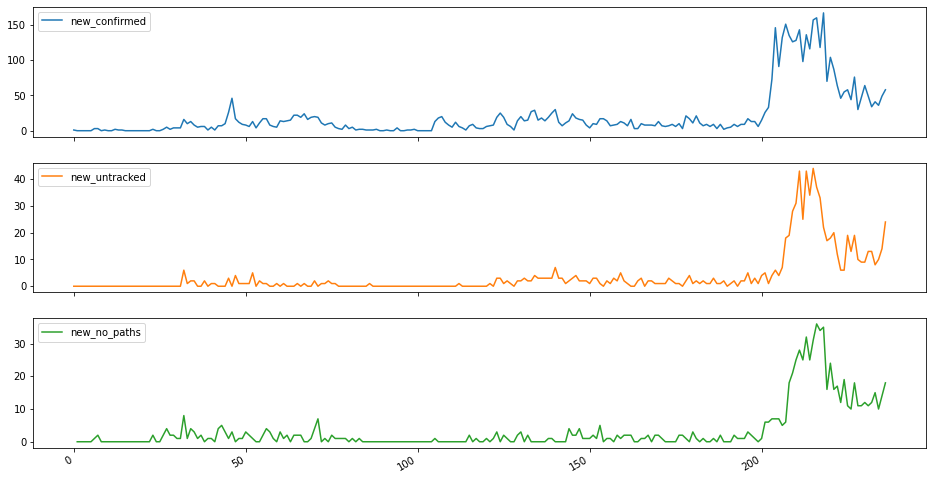

In [8]:
plot_cols = ['new_confirmed', 'new_untracked', 'new_no_paths']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(16,9))

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_confirmed,237.0,20.493671,33.886853,0.0,3.0,9.0,18.0,167.0
new_untracked,237.0,3.582278,7.733278,0.0,0.0,1.0,3.0,44.0
new_no_paths,236.0,3.411017,6.867479,0.0,0.0,1.0,2.0,36.0
is_holiday,237.0,0.033755,0.180981,0.0,0.0,0.0,0.0,1.0
is_weekend,237.0,0.430380,0.496177,0.0,0.0,0.0,1.0,1.0
gov_policy,237.0,0.354430,0.957194,0.0,0.0,0.0,0.0,3.0


In [ ]:
df = df[]

In [10]:
shift_days = 1
shift_steps = shift_days * 5
target_names = ['date','new_confirmed', 'new_untracked', 'new_no_paths']
df_targets = df[target_names]
df_targets.index = pd.DatetimeIndex(df_targets["date"])
df_targets = df_targets[['new_confirmed', 'new_untracked', 'new_no_paths']].shift(-shift_steps)

In [11]:
df_targets.tail(10)

,new_confirmed,new_untracked,new_no_paths
date,,,
2020-09-07,34.0,13.0,12.0
2020-09-08,41.0,8.0,15.0
2020-09-09,36.0,10.0,10.0
2020-09-10,49.0,14.0,14.0
2020-09-11,58.0,24.0,18.0
2020-09-12,NaN,NaN,NaN
2020-09-13,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN
2020-09-15,NaN,NaN,NaN


In [12]:
df = df_targets

In [13]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (232, 3)


In [14]:
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (232, 3)


In [15]:
num_data = len(x_data)
num_data

232

In [16]:
train_split = 0.9
num_train = int(train_split * num_data)
num_train

208

In [17]:
num_test = num_data - num_train
num_test

24

In [18]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)


232

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

232

In [20]:
num_x_signals = x_data.shape[1]
num_x_signals

3

In [21]:
num_y_signals = y_data.shape[1]
num_y_signals

3

In [22]:
x_train

array([[  0.,   0.,   0.],
       [  3.,   0.,   1.],
       [  3.,   0.,   2.],
       [  0.,   0.,   0.],
       [  1.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  2.,   0.,   0.],
       [  1.,   0.,   0.],
       [  1.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  2.,   0.,   2.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  2.,   0.,   2.],
       [  5.,   0.,   4.],
       [  2.,   0.,   2.],
       [  4.,   0.,   2.],
       [  4.,   0.,   1.],
       [  4.,   0.,   1.],
       [ 16.,   6.,   8.],
       [ 10.,   1.,   1.],
       [ 13.,   2.,   4.],
       [  8.,   2.,   3.],
       [  5.,   0.,   1.],
       [  6.,   0.,   2.],
       [  6.,   2.,   0.],
       [  1.,   0.,   1.],
       [  5.,   1.,   1.],
       [  1.,   1.,   0.],
 

In [23]:
x_scaler = MinMaxScaler()

In [24]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 151.0


In [25]:
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [26]:
x_test_scaled = x_scaler.transform(x_test)

In [27]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [28]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(208, 3)
(208, 3)


In [29]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [30]:
batch_size = 256

In [34]:
sequence_length = len(x_train_scaled) -1 
sequence_length

207

In [35]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [36]:
x_batch, y_batch = next(generator)

In [37]:
print(x_batch.shape)
print(y_batch.shape)

(256, 207, 3)
(256, 207, 3)


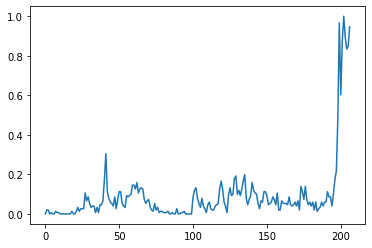

In [38]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

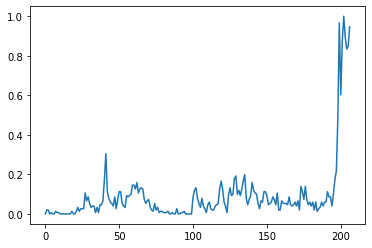

In [39]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [40]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [41]:
model = Sequential()

In [42]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [43]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [44]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [45]:
warmup_steps = 50

In [46]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [47]:
optimizer = RMSprop(lr=1e-3)

In [48]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         794112    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 795,651
Trainable params: 795,651
Non-trainable params: 0
_________________________________________________________________


In [50]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [51]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [52]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [53]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [54]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [55]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.2052WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - ETA: 0s - loss: 0.0308
Epoch 00001: val_loss did not improve from inf

Epoch 00001: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 4s 44ms/step - loss: 0.0308 - val_loss: nan
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0174
Epoch 00002: val_loss did not improve from inf

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 4s 40ms/step - loss: 0.0173 - val_loss: nan
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 0000

In [56]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '23_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [57]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: nan


In [58]:
print("loss (test-set):", result)

loss (test-set): nan


In [59]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        print(signal)
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

0


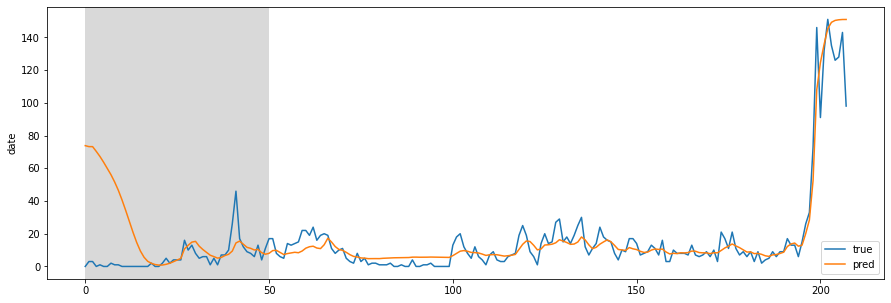

1


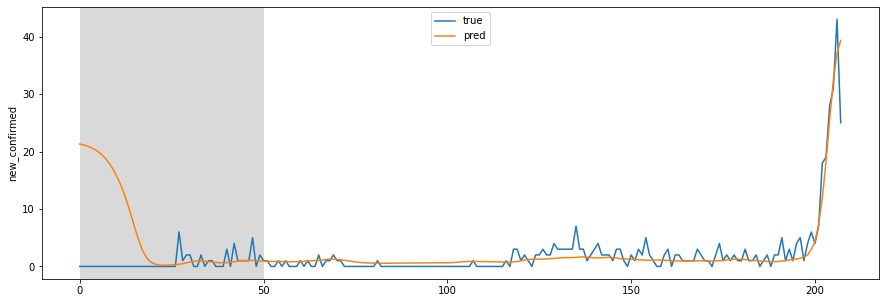

2


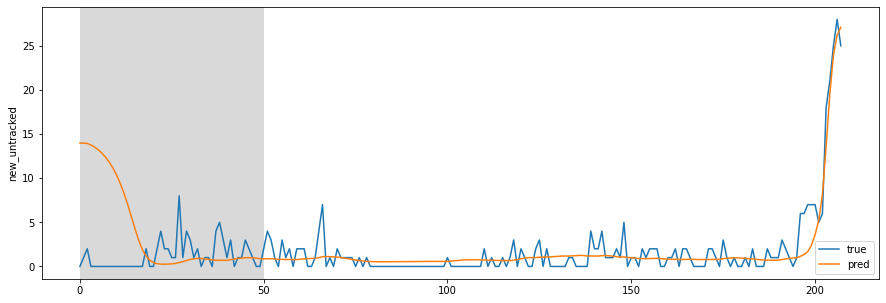

IndexError: ignored

In [60]:
plot_comparison(start_idx=0, length=231, train=True)

In [61]:
df

,new_confirmed,new_untracked,new_no_paths
date,,,
2020-01-24,0.0,0.0,0.0
2020-01-25,3.0,0.0,1.0
2020-01-26,3.0,0.0,2.0
2020-01-27,0.0,0.0,0.0
2020-01-28,1.0,0.0,0.0
...,...,...,...
2020-09-12,NaN,NaN,NaN
2020-09-13,NaN,NaN,NaN
2020-09-14,NaN,NaN,NaN
